In [1]:
import time
import pandas as pd
import numpy as np

In [2]:
start = time.time()

In [3]:
raw = pd.read_csv('tr_eikon_eod_data.csv', index_col = 0, parse_dates = True)
data = raw[['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']].dropna()

# Split data to train and test

In [4]:
# split the dataset into 80 (training) / 20 (testing)
from sklearn.model_selection import train_test_split
train, test = train_test_split(data,
                               test_size = 0.2,
                               shuffle = False,
                               random_state = 0) 

# Define relevant functions and model

In [6]:
# define a function to create n variables of n period lagged log returns
def lag(data, n):
    var = data.columns[1]
    for i in range(1, n):
        s = 'lag' + str(i)
        data[s] = data[var].shift(i)
    return data

In [7]:
# define model
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

LR_model = LinearRegression()
SFS_model = SequentialFeatureSelector(LR_model,
                                      scoring = 'r2')

In [8]:
# Stepwise regression to predict training data
def stepwise_regression_train(data_train, stock):
    train = pd.DataFrame(data_train[stock])
    train['log_price'] = np.log(train)
    train['log_ret'] = (np.log(train[train.columns[0]] / train[train.columns[0]].shift(1))).dropna()
    train = lag(train, 6).dropna()
    
    # Stepwise regression select features
    X_train = train.iloc[:,3:]
    y_train = train.iloc[:,1]

    sel_X_bool = SFS_model.fit(X_train, y_train).get_support()
    sel_X_train = X_train.loc[:, sel_X_bool]
    
    # perform linear regression on the selected variables to predict training data
    train['Predict_Step'] = LR_model.fit(sel_X_train, y_train).predict(sel_X_train)
    
    print('Selected variables are ' + str(list(sel_X_train.columns)))
    return train

In [9]:
# Stepwise regression to predict testing data
def stepwise_regression_test(data_train, data_test, stock):
    train = pd.DataFrame(data_train[stock])
    train['log_price'] = np.log(train)
    train['log_ret'] = (np.log(train[train.columns[0]] / train[train.columns[0]].shift(1))).dropna()
    train = lag(train, 6).dropna()
    
    test = pd.DataFrame(data_test[stock])
    test['log_price'] = np.log(test)
    test['log_ret'] = (np.log(test[test.columns[0]] / test[test.columns[0]].shift(1))).dropna()
    test = lag(test, 6).dropna()
    
    # Stepwise regression select features
    X_train = train.iloc[:,3:]
    y_train = train.iloc[:,1]

    sel_X_bool = SFS_model.fit(X_train, y_train).get_support()
    sel_X_train = X_train.loc[:, sel_X_bool]
    
    # Filter test data
    X_test = test.iloc[:,3:]
    sel_X_test = X_test.loc[:, sel_X_bool]
    
    # perform linear regression on the selected variables to predict training data
    test['Predict_Step'] = LR_model.fit(sel_X_train, y_train).predict(sel_X_test)
    
    print('Selected variables are ' + str(list(sel_X_train.columns)))
    return test

In [10]:
def trade(data):
    SMA_short = 50
    SMA_long = 200
    data['Predict_Price'] = np.exp(data['Predict_Step'])
    data['SMA_Short'] = data['Predict_Price'].rolling(SMA_short).mean()
    data['SMA_Long'] = data['Predict_Price'].rolling(SMA_long).mean()
    
    data.dropna(inplace = True)
    data['Position'] = np.where(data['SMA_Short'] > data['SMA_Long'], 1, -1)
    data['Predict_log_ret'] = np.log(data['Predict_Price'] / data['Predict_Price'].shift(1))
    data['SMA_Returns'] = data['Position'].shift(1) * data['log_ret']

    return data

In [11]:
def statistics(data):
    df = data
    # Actual Return
    ret = np.exp(np.sum(df['log_ret']))

    # Predicted returns
    pred_ret = np.exp(np.sum(df['Predict_log_ret']))
    
    # Strategy returns
    Predicted_Step = np.exp(np.sum(df['SMA_Returns']))

    # sharpe ratio assume rf = 0
    sharpe_ratio = df['SMA_Returns'].mean() / df['SMA_Returns'].std()
    
    # Number of trades (when position change)
    trades = (df['Position'].diff().dropna() != 0).sum()
    
    return pd.DataFrame([ret, pred_ret, Predicted_Step, sharpe_ratio, trades],
                        ['Actual return', 'Predicted return', 'Strategy return', 'Sharpe_ratio', 'Number of trades'],
                        [data.columns[0]])

# AAPL.O stepwise regression

### Prediction on training data

In [12]:
# Perform stepwise regression and predict returns
AAPLO_train = stepwise_regression_train(train, 'AAPL.O')

# Perform trading strategy
AAPLO_train = trade(AAPLO_train)
AAPLO_train

Selected variables are ['lag1', 'lag2']


,AAPL.O,log_price,log_ret,lag1,lag2,lag3,lag4,lag5,Predict_Step,Predict_Price,SMA_Short,SMA_Long,Position,Predict_log_ret,SMA_Returns
Date,,,,,,,,,,,,,,,
2010-10-25,44.119956,3.786912,0.004446,3.782466,3.789112,3.792369,3.789015,3.816140,3.784052,43.993950,39.329315,35.423164,1,NaN,NaN
2010-10-26,44.007099,3.784351,-0.002561,3.786912,3.782466,3.789112,3.792369,3.789015,3.788760,44.201550,39.500287,35.492360,1,0.004708,-0.002561
2010-10-27,43.975670,3.783637,-0.000714,3.784351,3.786912,3.782466,3.789112,3.792369,3.786033,44.081169,39.672938,35.562348,1,-0.002727,-0.000714
2010-10-28,43.605671,3.775187,-0.008449,3.783637,3.784351,3.786912,3.782466,3.789112,3.785365,44.051731,39.832220,35.633905,1,-0.000668,-0.008449
2010-10-29,42.997100,3.761133,-0.014055,3.775187,3.783637,3.784351,3.786912,3.782466,3.776743,43.673560,39.981023,35.701385,1,-0.008622,-0.014055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-11,116.300000,4.756173,0.002152,4.754021,4.736725,4.735233,4.727830,4.727388,4.754331,116.086009,109.742794,102.188382,1,0.017649,0.002152
2016-10-12,117.340000,4.765076,0.008903,4.756173,4.754021,4.736725,4.735233,4.727830,4.756110,116.292656,109.946613,102.229752,1,0.001779,0.008903
2016-10-13,116.980000,4.762003,-0.003073,4.765076,4.756173,4.754021,4.736725,4.735233,4.765160,117.349906,110.204583,102.282523,1,0.009050,-0.003073


In [13]:
statistics(AAPLO_train)

,AAPL.O
Actual return,2.676199
Predicted return,2.673771
Strategy return,3.803969
Sharpe_ratio,0.053828
Number of trades,4.000000


### Prediction on test data

In [14]:
AAPLO_test = stepwise_regression_test(train, test, 'AAPL.O')

# Perform trading strategy
AAPLO_test = trade(AAPLO_test)
AAPLO_test

Selected variables are ['lag1', 'lag2']


,AAPL.O,log_price,log_ret,lag1,lag2,lag3,lag4,lag5,Predict_Step,Predict_Price,SMA_Short,SMA_Long,Position,Predict_log_ret,SMA_Returns
Date,,,,,,,,,,,,,,,
2017-08-10,155.32,5.045488,-0.036289,5.081777,5.075674,5.067709,5.052353,5.047096,5.081187,160.965017,149.317707,134.724918,1,NaN,NaN
2017-08-11,157.48,5.059298,0.013811,5.045488,5.081777,5.075674,5.067709,5.052353,5.043933,155.078802,149.366472,134.912015,1,-0.037254,0.013811
2017-08-14,159.85,5.074236,0.014937,5.059298,5.045488,5.081777,5.075674,5.067709,5.058940,157.423482,149.453105,135.107896,1,0.015006,0.014937
2017-08-15,161.60,5.085124,0.010888,5.074236,5.059298,5.045488,5.081777,5.075674,5.073876,159.792452,149.540925,135.329289,1,0.014936,0.010888
2017-08-16,160.95,5.081094,-0.004030,5.085124,5.074236,5.059298,5.045488,5.081777,5.084645,161.522508,149.695519,135.564685,1,0.010769,-0.004030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.17,5.204940,-0.014983,5.219923,5.222839,5.228431,5.224079,5.240370,5.218849,184.721466,182.830757,171.784907,1,-0.002845,-0.014983
2018-06-26,184.43,5.217270,0.012330,5.204940,5.219923,5.222839,5.228431,5.224079,5.203601,181.926101,182.977516,171.888914,1,-0.015249,0.012330
2018-06-27,184.16,5.215805,-0.001465,5.217270,5.204940,5.219923,5.222839,5.228431,5.216573,184.301426,183.149798,172.018151,1,0.012972,-0.001465


In [15]:
statistics(AAPLO_test)

,AAPL.O
Actual return,1.149323
Predicted return,1.151466
Strategy return,1.191798
Sharpe_ratio,0.058594
Number of trades,0.000000


# MSFT.O Stepwise Regression

### Prediction on trained data

In [16]:
# Perform stepwise regression and predict returns
MSFTO_train = stepwise_regression_train(train, 'MSFT.O')

# Perform trading strategy
MSFTO_train = trade(MSFTO_train)
MSFTO_train

Selected variables are ['lag1', 'lag3']


,MSFT.O,log_price,log_ret,lag1,lag2,lag3,lag4,lag5,Predict_Step,Predict_Price,SMA_Short,SMA_Long,Position,Predict_log_ret,SMA_Returns
Date,,,,,,,,,,,,,,,
2010-10-25,25.190,3.226447,-0.007416,3.233863,3.235536,3.231200,3.222868,3.251149,3.234456,25.392557,24.606398,27.059877,-1,NaN,NaN
2010-10-26,25.900,3.254243,0.027796,3.226447,3.233863,3.235536,3.231200,3.222868,3.226926,25.202066,24.622243,27.032524,-1,-0.007530,-0.027796
2010-10-27,26.050,3.260018,0.005775,3.254243,3.226447,3.233863,3.235536,3.231200,3.255003,25.919680,24.650346,27.010713,-1,0.028077,-0.005775
2010-10-28,26.280,3.268808,0.008790,3.260018,3.254243,3.226447,3.233863,3.235536,3.260907,26.073181,24.677258,26.990690,-1,0.005905,-0.008790
2010-10-29,26.665,3.283352,0.014544,3.268808,3.260018,3.254243,3.226447,3.233863,3.269500,26.298174,24.706468,26.970358,-1,0.008592,-0.014544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-11,57.190,4.046379,-0.014753,4.061132,4.056989,4.055950,4.054217,4.047253,4.061221,58.045132,57.532214,53.814466,1,0.004165,-0.014753
2016-10-12,57.110,4.044979,-0.001400,4.046379,4.061132,4.056989,4.055950,4.054217,4.046317,57.186449,57.544208,53.822015,1,-0.014904,-0.001400
2016-10-13,56.920,4.041647,-0.003332,4.044979,4.046379,4.061132,4.056989,4.055950,4.044862,57.103299,57.554635,53.827758,1,-0.001455,-0.003332


In [17]:
statistics(MSFTO_train)

,MSFT.O
Actual return,2.254753
Predicted return,2.261513
Strategy return,0.710711
Sharpe_ratio,-0.015405
Number of trades,11.000000


### Prediction on test data

In [18]:
MSFTO_test = stepwise_regression_test(train, test, 'MSFT.O')

# Perform trading strategy
MSFTO_test = trade(MSFTO_test)
MSFTO_test

Selected variables are ['lag1', 'lag3']


,MSFT.O,log_price,log_ret,lag1,lag2,lag3,lag4,lag5,Predict_Step,Predict_Price,SMA_Short,SMA_Long,Position,Predict_log_ret,SMA_Returns
Date,,,,,,,,,,,,,,,
2017-08-10,71.41,4.268438,-0.014735,4.283173,4.287579,4.282206,4.286066,4.278747,4.283076,72.462999,71.369745,65.854191,1,NaN,NaN
2017-08-11,72.50,4.283587,0.015149,4.268438,4.283173,4.287579,4.282206,4.286066,4.268147,71.389235,71.400870,65.905940,1,-0.014929,0.015149
2017-08-14,73.59,4.298509,0.014923,4.283587,4.268438,4.283173,4.287579,4.282206,4.283484,72.492571,71.448903,65.963384,1,0.015337,0.014923
2017-08-15,73.22,4.293469,-0.005041,4.298509,4.283587,4.268438,4.283173,4.287579,4.298698,73.603863,71.485530,66.028269,1,0.015213,-0.005041
2017-08-16,73.65,4.299324,0.005856,4.293469,4.298509,4.283587,4.268438,4.283173,4.293456,73.219055,71.504014,66.093905,1,-0.005242,0.005856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,98.39,4.588939,-0.020323,4.609262,4.616506,4.623697,4.613733,4.613733,4.608800,100.363658,97.741971,88.596591,1,-0.007414,-0.020323
2018-06-26,99.08,4.595928,0.006988,4.588939,4.609262,4.616506,4.623697,4.613733,4.588358,98.332792,97.847275,88.716563,1,-0.020443,0.006988
2018-06-27,97.54,4.580263,-0.015665,4.595928,4.588939,4.609262,4.616506,4.623697,4.595486,99.036223,97.944996,88.841859,1,0.007128,-0.015665


In [19]:
statistics(MSFTO_test)

,MSFT.O
Actual return,1.360701
Predicted return,1.360632
Strategy return,1.380899
Sharpe_ratio,0.100997
Number of trades,0.000000


# INTC.O Stepwise regression

### Prediction on train data

In [20]:
# Perform stepwise regression and predict returns
INTCO_train = stepwise_regression_train(train, 'INTC.O')

# Perform trading strategy
INTCO_train = trade(INTCO_train)
INTCO_train

Selected variables are ['lag1', 'lag2']


,INTC.O,log_price,log_ret,lag1,lag2,lag3,lag4,lag5,Predict_Step,Predict_Price,SMA_Short,SMA_Long,Position,Predict_log_ret,SMA_Returns
Date,,,,,,,,,,,,,,,
2010-10-25,19.87,2.989211,0.001763,2.987448,2.983660,2.977568,2.955431,2.954389,2.988315,19.852211,18.959857,20.707687,-1,NaN,NaN
2010-10-26,20.04,2.997730,0.008519,2.989211,2.987448,2.983660,2.977568,2.955431,2.990108,19.887831,18.974129,20.702909,-1,0.001793,-0.008519
2010-10-27,20.19,3.005187,0.007457,2.997730,2.989211,2.987448,2.983660,2.977568,2.998497,20.055370,18.985565,20.698361,-1,0.008389,-0.007457
2010-10-28,20.47,3.018960,0.013773,3.005187,2.997730,2.989211,2.987448,2.983660,3.005955,20.205511,18.998719,20.696233,-1,0.007458,-0.013773
2010-10-29,20.05,2.998229,-0.020731,3.018960,3.005187,2.997730,2.989211,2.987448,3.019594,20.482973,19.016223,20.693793,-1,0.013639,0.020731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-11,37.27,3.618189,-0.019924,3.638112,3.640214,3.639427,3.637323,3.625407,3.637658,38.002726,36.074734,32.720576,1,-0.002050,-0.019924
2016-10-12,37.13,3.614425,-0.003763,3.618189,3.638112,3.640214,3.639427,3.637323,3.618072,37.265663,36.123253,32.732056,1,-0.019586,-0.003763
2016-10-13,36.97,3.610107,-0.004318,3.614425,3.618189,3.638112,3.640214,3.639427,3.614050,37.116068,36.174473,32.743035,1,-0.004022,-0.004318


In [21]:
statistics(INTCO_train)

,INTC.O
Actual return,1.880010
Predicted return,1.885177
Strategy return,0.796105
Sharpe_ratio,-0.010434
Number of trades,13.000000


### Prediction on test data

In [22]:
INTCO_test = stepwise_regression_test(train, test, 'INTC.O')

# Perform trading strategy
INTCO_test = trade(INTCO_test)
INTCO_test

Selected variables are ['lag1', 'lag2']


,INTC.O,log_price,log_ret,lag1,lag2,lag3,lag4,lag5,Predict_Step,Predict_Price,SMA_Short,SMA_Long,Position,Predict_log_ret,SMA_Returns
Date,,,,,,,,,,,,,,,
2017-08-10,36.14,3.587400,-0.012375,3.599775,3.594843,3.595393,3.591818,3.597038,3.599288,36.572182,35.064817,35.689687,-1,NaN,NaN
2017-08-11,35.87,3.579901,-0.007499,3.587400,3.599775,3.594843,3.595393,3.591818,3.587226,36.133712,35.065540,35.694122,-1,-0.012062,0.007499
2017-08-14,36.34,3.592919,0.013018,3.579901,3.587400,3.599775,3.594843,3.595393,3.579663,35.861455,35.060645,35.697971,-1,-0.007563,-0.013018
2017-08-15,36.00,3.583519,-0.009400,3.592919,3.579901,3.587400,3.599775,3.594843,3.592313,36.317991,35.060954,35.705000,-1,0.012650,0.009400
2017-08-16,35.81,3.578227,-0.005292,3.583519,3.592919,3.579901,3.587400,3.599775,3.583304,35.992271,35.054290,35.710953,-1,-0.009009,0.005292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,50.71,3.926123,-0.034690,3.960813,3.954891,3.978934,3.968970,3.974434,3.959522,52.432271,53.892365,47.075665,1,0.005414,-0.034690
2018-06-26,49.67,3.905401,-0.020722,3.926123,3.960813,3.954891,3.978934,3.968970,3.925579,50.682428,53.869741,47.151420,1,-0.033943,-0.020722
2018-06-27,48.76,3.886910,-0.018491,3.905401,3.926123,3.960813,3.954891,3.978934,3.904672,49.633774,53.815840,47.223666,1,-0.020908,-0.018491


In [23]:
statistics(INTCO_test)

,INTC.O
Actual return,1.358568
Predicted return,1.345011
Strategy return,1.178724
Sharpe_ratio,0.039599
Number of trades,1.000000


# AMZN.O Stepwise Regression

### Prediction on train data

In [24]:
# Perform stepwise regression and predict returns
AMZNO_train = stepwise_regression_train(train, 'AMZN.O')

# Perform trading strategy
AMZNO_train = trade(AMZNO_train)
AMZNO_train

Selected variables are ['lag1', 'lag5']


,AMZN.O,log_price,log_ret,lag1,lag2,lag3,lag4,lag5,Predict_Step,Predict_Price,SMA_Short,SMA_Long,Position,Predict_log_ret,SMA_Returns
Date,,,,,,,,,,,,,,,
2010-10-25,169.00,5.129899,-0.000769,5.130668,5.105764,5.066827,5.066827,5.097180,5.131163,169.213810,145.729659,131.248924,1,NaN,NaN
2010-10-26,169.95,5.135504,0.005606,5.129899,5.130668,5.105764,5.066827,5.066827,5.129770,168.978245,146.610627,131.425356,1,-0.001393,0.005606
2010-10-27,167.51,5.121043,-0.014461,5.135504,5.129899,5.130668,5.105764,5.066827,5.135257,169.907931,147.482644,131.622100,1,0.005487,-0.014461
2010-10-28,166.84,5.117035,-0.004008,5.121043,5.135504,5.129899,5.130668,5.105764,5.121924,167.657568,148.256696,131.822346,1,-0.013333,-0.004008
2010-10-29,165.23,5.107338,-0.009697,5.117035,5.121043,5.135504,5.129899,5.130668,5.118526,167.088944,149.003608,132.011353,1,-0.003397,-0.009697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-11,831.00,6.722630,-0.012806,6.735436,6.732723,6.735376,6.738579,6.726269,6.736285,842.425250,784.608198,677.342821,1,0.002586,-0.012806
2016-10-12,834.09,6.726341,0.003712,6.722630,6.735436,6.732723,6.735376,6.738579,6.724010,832.148070,785.894066,678.185933,1,-0.012275,0.003712
2016-10-13,829.28,6.720558,-0.005783,6.726341,6.722630,6.735436,6.732723,6.735376,6.727576,835.120185,787.379105,678.983075,1,0.003565,-0.005783


In [25]:
statistics(AMZNO_train)

,AMZN.O
Actual return,4.806658
Predicted return,4.870833
Strategy return,1.872069
Sharpe_ratio,0.020507
Number of trades,6.000000


### Prediction on test data

In [26]:
AMZNO_test = stepwise_regression_test(train, test, 'AMZN.O')

# Perform trading strategy
AMZNO_test = trade(AMZNO_test)
AMZNO_test

Selected variables are ['lag1', 'lag5']


,AMZN.O,log_price,log_ret,lag1,lag2,lag3,lag4,lag5,Predict_Step,Predict_Price,SMA_Short,SMA_Long,Position,Predict_log_ret,SMA_Returns
Date,,,,,,,,,,,,,,,
2017-08-10,956.92,6.863720,-0.025882,6.889601,6.897543,6.899995,6.895258,6.894589,6.890734,983.122996,998.719471,879.981420,1,NaN,NaN
2017-08-11,967.99,6.875222,0.011502,6.863720,6.889601,6.897543,6.899995,6.895258,6.865415,958.543853,997.983594,880.581500,1,-0.025319,0.011502
2017-08-14,983.30,6.890914,0.015693,6.875222,6.863720,6.889601,6.897543,6.899995,6.876773,969.493151,997.435094,881.250572,1,0.011358,0.015693
2017-08-15,982.74,6.890345,-0.000570,6.890914,6.875222,6.863720,6.889601,6.897543,6.892082,984.448428,996.973464,882.056869,1,0.015308,-0.000570
2017-08-16,978.18,6.885694,-0.004651,6.890345,6.890914,6.875222,6.863720,6.889601,6.891356,983.734796,996.406854,882.879396,1,-0.000725,-0.004651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,1663.15,7.416469,-0.031090,7.447559,7.456004,7.467417,7.458636,7.452281,7.448631,1717.509812,1609.654319,1332.082232,1,-0.008170,-0.031090
2018-06-26,1691.09,7.433129,0.016660,7.416469,7.447559,7.456004,7.467417,7.458636,7.418334,1666.254612,1614.345790,1335.510999,1,-0.030297,0.016660
2018-06-27,1660.51,7.414880,-0.018249,7.433129,7.416469,7.447559,7.456004,7.467417,7.434826,1693.962329,1619.368732,1339.145042,1,0.016492,-0.018249


In [27]:
statistics(AMZNO_test)

,AMZN.O
Actual return,1.730940
Predicted return,1.732647
Strategy return,1.776324
Sharpe_ratio,0.151477
Number of trades,0.000000


# GS.N Stepwise regression

### Prediction on train data

In [28]:
# Perform stepwise regression and predict returns
GSN_train = stepwise_regression_train(train, 'GS.N')

# Perform trading strategy
GSN_train = trade(GSN_train)
GSN_train

Selected variables are ['lag1', 'lag2']


,GS.N,log_price,log_ret,lag1,lag2,lag3,lag4,lag5,Predict_Step,Predict_Price,SMA_Short,SMA_Long,Position,Predict_log_ret,SMA_Returns
Date,,,,,,,,,,,,,,,
2010-10-25,157.39,5.058727,-0.002348,5.061075,5.070789,5.072671,5.054461,5.035003,5.061575,157.838995,148.686024,152.511604,-1,NaN,NaN
2010-10-26,158.29,5.064429,0.005702,5.058727,5.061075,5.070789,5.072671,5.054461,5.058726,157.389901,148.870249,152.426295,-1,-0.002849,-0.005702
2010-10-27,160.15,5.076111,0.011682,5.064429,5.058727,5.061075,5.070789,5.072671,5.063852,158.198800,149.078435,152.358936,-1,0.005126,-0.011682
2010-10-28,163.24,5.095222,0.019111,5.076111,5.064429,5.058727,5.061075,5.070789,5.075082,159.985267,149.307397,152.318802,-1,0.011229,-0.019111
2010-10-29,160.95,5.081094,-0.014128,5.095222,5.076111,5.064429,5.058727,5.061075,5.093614,162.977854,149.583746,152.289117,-1,0.018533,0.014128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-11,169.04,5.130135,-0.011762,5.141897,5.134798,5.118892,5.114395,5.089262,5.140963,170.880211,165.258677,158.630427,1,0.007684,-0.011762
2016-10-12,169.30,5.131672,0.001537,5.130135,5.141897,5.134798,5.118892,5.114395,5.130544,169.109121,165.476960,158.564061,1,-0.010419,0.001537
2016-10-13,167.42,5.120506,-0.011167,5.131672,5.130135,5.141897,5.134798,5.118892,5.131157,169.212728,165.737521,158.502319,1,0.000612,-0.011167


In [29]:
statistics(GSN_train)

,GS.N
Actual return,1.071247
Predicted return,1.078504
Strategy return,0.895805
Sharpe_ratio,-0.004380
Number of trades,9.000000


### Prediction on test data

In [30]:
GSN_test = stepwise_regression_test(train, test, 'GS.N')

# Perform trading strategy
GSN_test = trade(GSN_test)
GSN_test

Selected variables are ['lag1', 'lag2']


,GS.N,log_price,log_ret,lag1,lag2,lag3,lag4,lag5,Predict_Step,Predict_Price,SMA_Short,SMA_Long,Position,Predict_log_ret,SMA_Returns
Date,,,,,,,,,,,,,,,
2017-08-10,225.50,5.418320,-0.024141,5.442461,5.446953,5.450695,5.437166,5.411601,5.441312,230.744737,222.951891,226.268367,-1,NaN,NaN
2017-08-11,224.15,5.412315,-0.006005,5.418320,5.442461,5.446953,5.450695,5.437166,5.418611,225.565582,223.233156,226.521208,-1,-0.022701,0.006005
2017-08-14,227.36,5.426535,0.014219,5.412315,5.418320,5.442461,5.446953,5.450695,5.411373,223.938834,223.422183,226.763768,-1,-0.007238,-0.014219
2017-08-15,227.59,5.427546,0.001011,5.426535,5.412315,5.418320,5.442461,5.446953,5.424146,226.817608,223.695070,227.013530,-1,0.012773,-0.001011
2017-08-16,225.61,5.418808,-0.008738,5.427546,5.426535,5.412315,5.418320,5.442461,5.426067,227.253662,223.966420,227.261793,-1,0.001921,0.008738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,221.54,5.400603,-0.020020,5.420623,5.424862,5.428556,5.430748,5.444105,5.419531,225.773169,237.217347,246.396484,-1,-0.004186,0.020020
2018-06-26,221.58,5.400784,0.000181,5.400603,5.420623,5.424862,5.428556,5.430748,5.400669,221.554585,236.534240,246.425358,-1,-0.018862,-0.000181
2018-06-27,220.18,5.394445,-0.006338,5.400784,5.400603,5.420623,5.424862,5.428556,5.399453,221.285254,235.814495,246.447567,-1,-0.001216,0.006338


In [31]:
statistics(GSN_test)

,GS.N
Actual return,0.954807
Predicted return,0.965977
Strategy return,0.895598
Sharpe_ratio,-0.036120
Number of trades,2.000000


# Combined statistics

#### Summary from predicting training data

In [32]:
statistics(AAPLO_train).join(statistics(MSFTO_train)).join(statistics(INTCO_train)).join(statistics(AMZNO_train)).join(statistics(GSN_train))

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N
Actual return,2.676199,2.254753,1.880010,4.806658,1.071247
Predicted return,2.673771,2.261513,1.885177,4.870833,1.078504
Strategy return,3.803969,0.710711,0.796105,1.872069,0.895805
Sharpe_ratio,0.053828,-0.015405,-0.010434,0.020507,-0.004380
Number of trades,4.000000,11.000000,13.000000,6.000000,9.000000


<Axes: title={'center': 'AAPL.O train'}, xlabel='Date'>

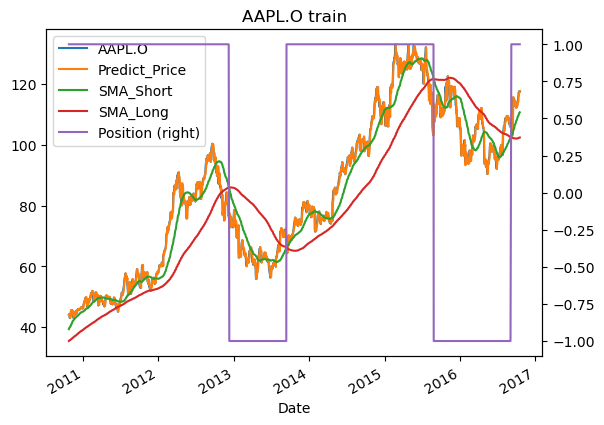

In [33]:
AAPLO_train[['AAPL.O', 'Predict_Price', 'SMA_Short', 'SMA_Long', 'Position']].plot(secondary_y = 'Position', title = 'AAPL.O train')

<Axes: title={'center': 'MSFT.O train'}, xlabel='Date'>

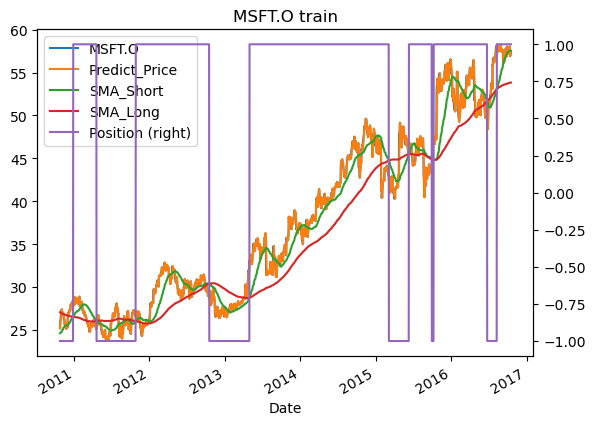

In [34]:
MSFTO_train[['MSFT.O', 'Predict_Price', 'SMA_Short', 'SMA_Long', 'Position']].plot(secondary_y = 'Position', title = 'MSFT.O train')

<Axes: title={'center': 'INTC.O train'}, xlabel='Date'>

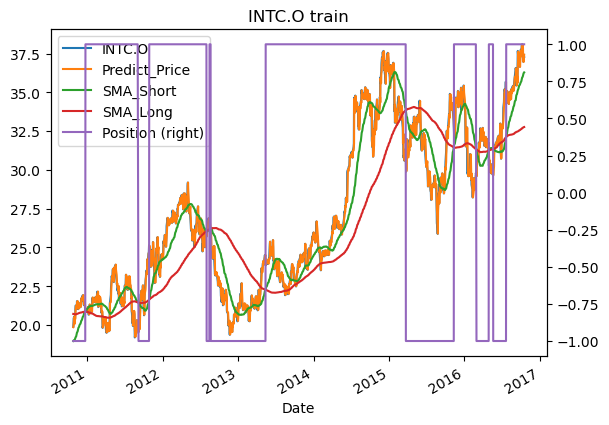

In [35]:
INTCO_train[['INTC.O', 'Predict_Price', 'SMA_Short', 'SMA_Long', 'Position']].plot(secondary_y = 'Position', title = 'INTC.O train')

<Axes: title={'center': 'AMZN.O train'}, xlabel='Date'>

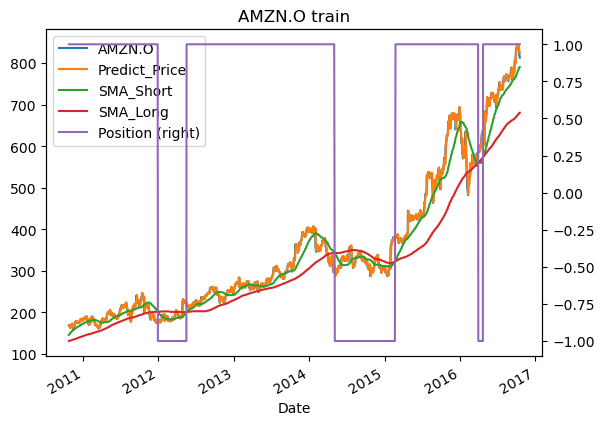

In [36]:
AMZNO_train[['AMZN.O', 'Predict_Price', 'SMA_Short', 'SMA_Long', 'Position']].plot(secondary_y = 'Position', title = 'AMZN.O train')

<Axes: title={'center': 'GS.N train'}, xlabel='Date'>

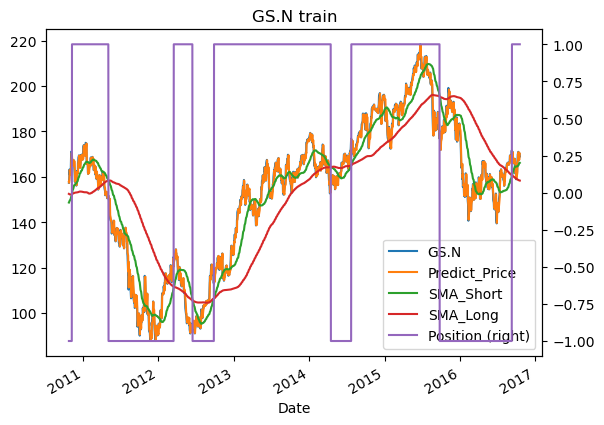

In [37]:
GSN_train[['GS.N', 'Predict_Price', 'SMA_Short', 'SMA_Long', 'Position']].plot(secondary_y = 'Position', title = 'GS.N train')

#### Summary from predicting test data 

In [38]:
# Summary statistics from test data
statistics(AAPLO_test).join(statistics(MSFTO_test)).join(statistics(INTCO_test)).join(statistics(AMZNO_test)).join(statistics(GSN_test))

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N
Actual return,1.149323,1.360701,1.358568,1.730940,0.954807
Predicted return,1.151466,1.360632,1.345011,1.732647,0.965977
Strategy return,1.191798,1.380899,1.178724,1.776324,0.895598
Sharpe_ratio,0.058594,0.100997,0.039599,0.151477,-0.036120
Number of trades,0.000000,0.000000,1.000000,0.000000,2.000000


<Axes: title={'center': 'AAPL.O test'}, xlabel='Date'>

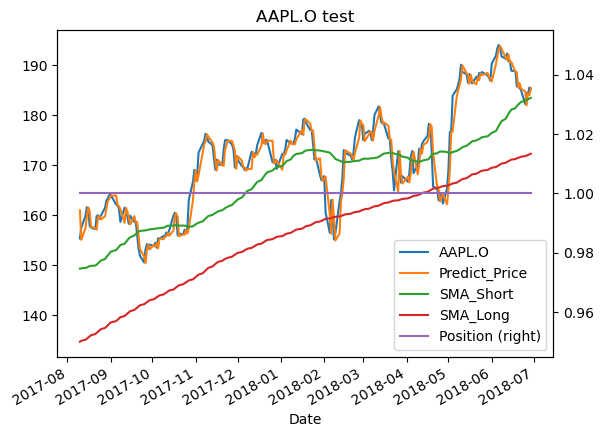

In [39]:
AAPLO_test[['AAPL.O', 'Predict_Price', 'SMA_Short', 'SMA_Long', 'Position']].plot(secondary_y = 'Position', title = 'AAPL.O test')

<Axes: title={'center': 'MSFT.O test'}, xlabel='Date'>

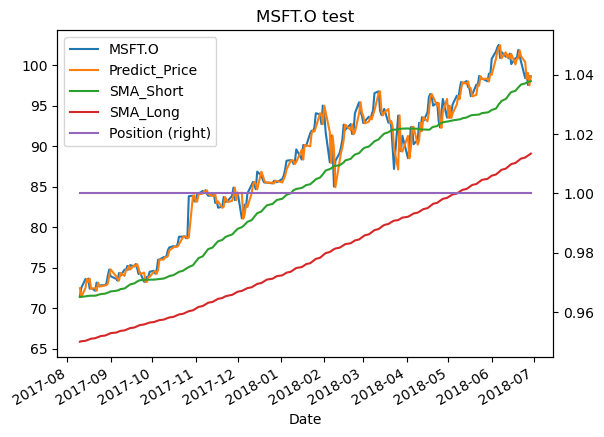

In [40]:
MSFTO_test[['MSFT.O', 'Predict_Price', 'SMA_Short', 'SMA_Long', 'Position']].plot(secondary_y = 'Position', title = 'MSFT.O test')

<Axes: title={'center': 'INTC.O test'}, xlabel='Date'>

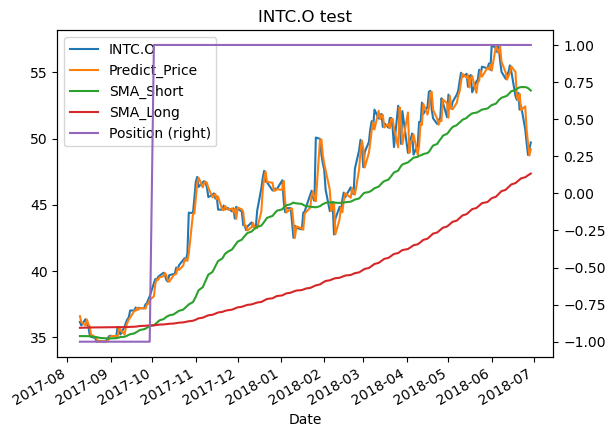

In [41]:
INTCO_test[['INTC.O', 'Predict_Price', 'SMA_Short', 'SMA_Long', 'Position']].plot(secondary_y = 'Position', title = 'INTC.O test')

<Axes: title={'center': 'AMZN.O test'}, xlabel='Date'>

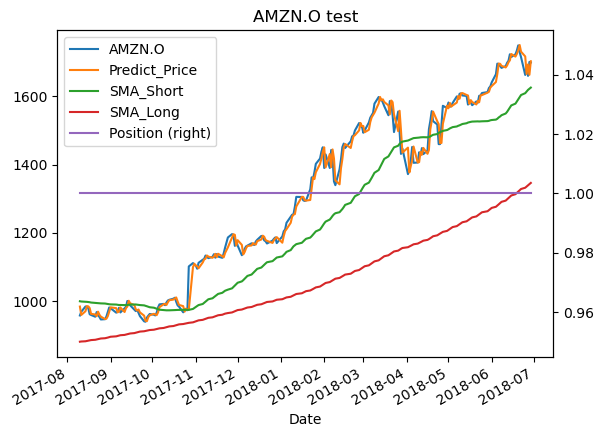

In [42]:
AMZNO_test[['AMZN.O', 'Predict_Price', 'SMA_Short', 'SMA_Long', 'Position']].plot(secondary_y = 'Position', title = 'AMZN.O test')

<Axes: title={'center': 'GS.N test'}, xlabel='Date'>

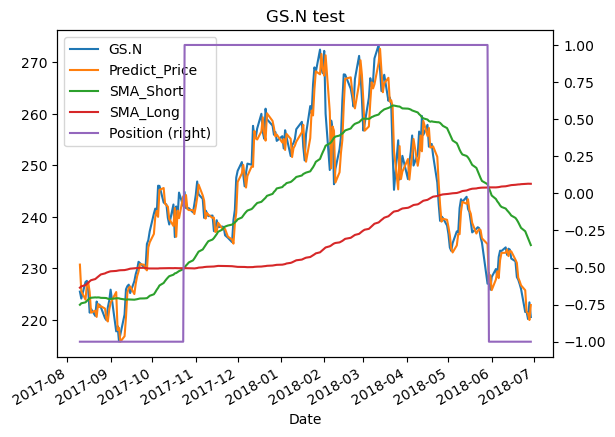

In [43]:
GSN_test[['GS.N', 'Predict_Price', 'SMA_Short', 'SMA_Long', 'Position']].plot(secondary_y = 'Position', title = 'GS.N test')

In [44]:
end = time.time()
end-start

19.201006650924683